In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
algorithm = 'KNN'
precision = 4
MDC_events = pd.read_csv('matrix_'+algorithm+'_MDC11.csv',delimiter=',',index_col=False)

num_classifications = 50
Bayes = pd.read_csv('BayesFactors.csv',delimiter=',')

P_NS_given_X1pX2_table_an_Bayes = pd.read_csv(algorithm+'_P_NS_given_X1pX2-BF-fit.csv')
P_REM_given_X2_table_an_Bayes = pd.read_csv(algorithm+'_P_REM_given_X2-BF-fit.csv')

In [3]:
MDC_probabilities=pd.DataFrame(columns=['event', 'P_NS','P_REM'])

X_events = (MDC_events.iloc[:,8:]*num_classifications).astype(np.int32)
param_events = MDC_events.iloc[:,:8]

[X_events.insert(0,'X1pX2_'+EOS,X_events['f1_'+EOS]+X_events['f2_'+EOS]) for EOS in Bayes['EOS']]
[X_events.drop(columns=['f0_'+EOS],inplace=True) for EOS in Bayes['EOS']]
[X_events.drop(columns=['f1_'+EOS],inplace=True) for EOS in Bayes['EOS']]
[X_events.rename(columns={'f2_'+EOS:'X2_'+EOS}, inplace=True) for EOS in Bayes['EOS']]

for event in range(len(X_events)):
    for EOS in Bayes['EOS']:
        X_events.at[event,'X1pX2_'+EOS]  = \
            P_NS_given_X1pX2_table_an_Bayes.loc[X_events.loc[event,'X1pX2_'+EOS],'P_NS('+EOS+')']
        X_events.at[event,'X2_'+EOS]  = \
            P_REM_given_X2_table_an_Bayes.loc[X_events.loc[event,'X2_'+EOS],'P_REM('+EOS+')']

P_NS_labels =[]
P_REM_labels =[]

[P_NS_labels.append('X1pX2_'+EOS) for EOS in Bayes['EOS']]
[P_REM_labels.append('X2_'+EOS) for EOS in Bayes['EOS']]

X_events.insert(0,'P_NS',X_events.loc[:,P_NS_labels].sum(axis=1))
X_events.insert(1,'P_REM',X_events.loc[:,P_REM_labels].sum(axis=1))

X_events = X_events.iloc[: , :2]
X_events = X_events.round(decimals=precision)
p_events=param_events.join(X_events)

display(p_events)
p_events.to_csv(algorithm+'_MDC_probabilities.csv',index=False)

,m1_rec,m2_rec,chi1_rec,chi2_rec,snr,pipeline,HasNS_true,HasREM_true,P_NS,P_REM
0,4.268033,3.634232,-0.913736,0.450203,18.991429,spiir,1,0,0.5864,0.0000
1,6.268945,2.588275,-0.146668,0.099328,19.285233,pycbc,1,0,0.8964,0.0001
2,12.247071,1.550140,0.370892,0.019994,19.721900,spiir,1,0,0.8876,0.0142
3,6.154887,2.612731,-0.016768,-0.532756,18.754279,spiir,1,0,0.8964,0.0001
4,21.466118,1.100672,0.726591,0.007167,15.509615,spiir,1,0,0.7636,0.0084
...,...,...,...,...,...,...,...,...,...,...
31586,17.241377,1.780054,0.528739,0.201094,9.838356,pycbc,1,0,0.5663,0.0000
31587,44.371793,1.054529,0.864736,0.000000,9.730664,MBTA,1,0,0.9884,0.0001
31588,25.004959,1.240039,0.436992,0.436992,9.617538,gstlal,1,0,0.6093,0.0000
31589,5.242820,5.044560,0.568023,0.568023,8.692800,pycbc,1,0,0.4817,0.0022


In [4]:
p_events_store = p_events

custom_legend = [Line2D([], [], marker='o', markersize=12, linestyle='None'),
          Line2D([], [], marker='+', markersize=12, linestyle='None'),
          Line2D([], [], marker='x', markersize=12, linestyle='None'),
          Line2D([], [], marker='*', markersize=12, linestyle='None'),
          Line2D([], [], marker='D', markersize=12, linestyle='None')
         ]

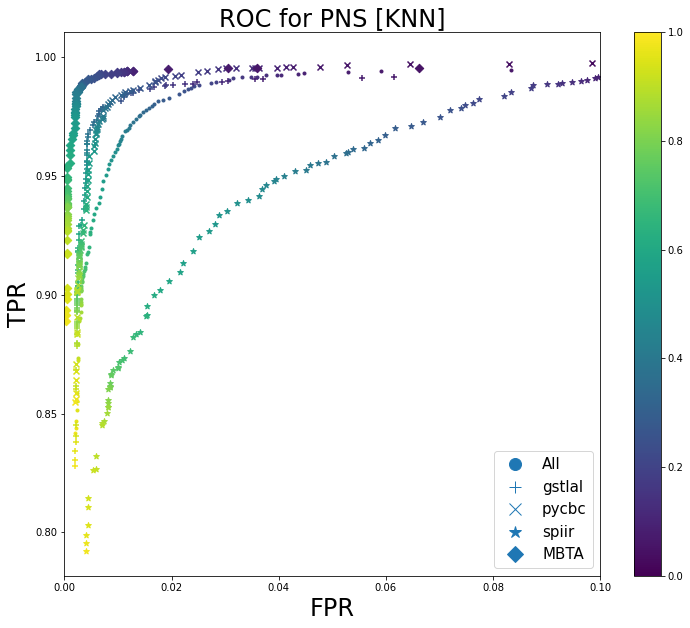

In [5]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)

ax.set_xlim([0,.1])
ax.set_xlabel('FPR',fontsize=24)
ax.set_ylabel('TPR',fontsize=24)
ax.set_title('ROC for PNS ['+algorithm+']',fontsize=24)

for pns in np.linspace(0,1,101):
    HasNS = p_events[p_events['HasNS_true']>0]
    non_HasNS = p_events[p_events['HasNS_true']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(HasNS)
    pns_roc = ax.scatter(fpr,tpr,c=pns,cmap='viridis',vmin=0, vmax=1, marker='.')

p_events = p_events_store[p_events_store['pipeline']=='gstlal']
    
for pns in np.linspace(0,1,101):
    HasNS = p_events[p_events['HasNS_true']>0]
    non_HasNS = p_events[p_events['HasNS_true']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(HasNS)
    pns_roc = ax.scatter(fpr,tpr,c=pns,cmap='viridis',vmin=0, vmax=1, marker='+')

p_events = p_events_store[p_events_store['pipeline']=='pycbc']
    
for pns in np.linspace(0,1,101):
    HasNS = p_events[p_events['HasNS_true']>0]
    non_HasNS = p_events[p_events['HasNS_true']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(HasNS)
    pns_roc = ax.scatter(fpr,tpr,c=pns,cmap='viridis',vmin=0, vmax=1,marker='x')

p_events = p_events_store[p_events_store['pipeline']=='spiir']
    
for pns in np.linspace(0,1,101):
    HasNS = p_events[p_events['HasNS_true']>0]
    non_HasNS = p_events[p_events['HasNS_true']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(HasNS)
    pns_roc = ax.scatter(fpr,tpr,c=pns,cmap='viridis',vmin=0, vmax=1,marker='*')
    
p_events = p_events_store[p_events_store['pipeline']=='MBTA']
    
for pns in np.linspace(0,1,101):
    HasNS = p_events[p_events['HasNS_true']>0]
    non_HasNS = p_events[p_events['HasNS_true']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(HasNS)
    pns_roc = ax.scatter(fpr,tpr,c=pns,cmap='viridis',vmin=0, vmax=1,marker='D')

plt.legend(custom_legend, ['All', 'gstlal', 'pycbc', 'spiir', 'MBTA'], loc='lower right', fontsize=15)
    
plt.colorbar(pns_roc)
plt.savefig(algorithm+'_roc_PNS.png',dpi=300, facecolor='w')

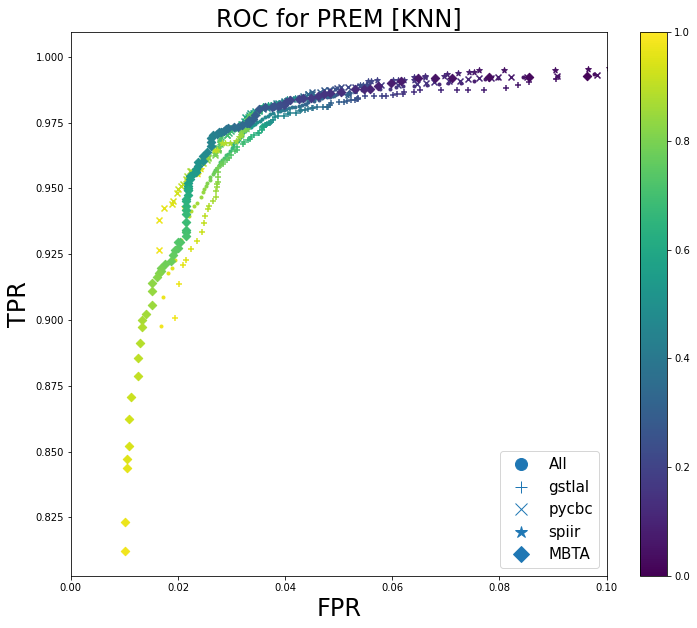

In [6]:
p_events = p_events_store

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)

ax.set_xlim([0,.1])
ax.set_xlabel('FPR',fontsize=24)
ax.set_ylabel('TPR',fontsize=24)
ax.set_title('ROC for PREM ['+algorithm+']',fontsize=24)

for prem in np.linspace(0,1,101):
    HasREM = p_events[p_events['HasREM_true']>0]
    non_HasREM = p_events[p_events['HasREM_true']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(HasREM)
    prem_roc = ax.scatter(fpr,tpr,c=prem,cmap='viridis',vmin=0, vmax=1, marker='.')

    
p_events = p_events_store[p_events_store['pipeline']=='gstlal']
    
for prem in np.linspace(0,1,101):
    HasREM = p_events[p_events['HasREM_true']>0]
    non_HasREM = p_events[p_events['HasREM_true']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(HasREM)
    prem_roc = ax.scatter(fpr,tpr,c=prem,cmap='viridis',vmin=0, vmax=1,  marker='+')

p_events = p_events_store[p_events_store['pipeline']=='pycbc']
    
for prem in np.linspace(0,1,101):
    HasREM = p_events[p_events['HasREM_true']>0]
    non_HasREM = p_events[p_events['HasREM_true']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(HasREM)
    prem_roc = ax.scatter(fpr,tpr,c=prem,cmap='viridis',vmin=0, vmax=1, marker='x')

p_events = p_events_store[p_events_store['pipeline']=='spiir']
    
for prem in np.linspace(0,1,101):
    HasREM = p_events[p_events['HasREM_true']>0]
    non_HasREM = p_events[p_events['HasREM_true']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(HasREM)
    prem_roc = ax.scatter(fpr,tpr,c=prem,cmap='viridis',vmin=0, vmax=1, marker='*')
       
p_events = p_events_store[p_events_store['pipeline']=='MBTA']
    
for prem in np.linspace(0,1,101):
    HasREM = p_events[p_events['HasREM_true']>0]
    non_HasREM = p_events[p_events['HasREM_true']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(HasREM)
    prem_roc = ax.scatter(fpr,tpr,c=prem,cmap='viridis',vmin=0, vmax=1, marker='D')

plt.legend(custom_legend, ['All', 'gstlal', 'pycbc', 'spiir', 'MBTA'], loc='lower right', fontsize=15)
        
plt.colorbar(prem_roc)
plt.savefig(algorithm+'_roc_PREM.png',dpi=300, facecolor='w')